# Report HW0
### 0656109 黃慎航

## 1.Preprocessing Task
**Remove Bad data:**

移除anomal data並且將data數量過少的sensor移除，threshold是平均數減一個標準差

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d
from scipy import signal

df = pd.DataFrame(pd.read_csv('201703_Taiwan.csv'))
#remove anomal data and count data size of each device
df2 = df[(df['PM2.5'] > 0) & (df['PM10'] > 0) & (df['PM1'] > 0)].groupby('device_id').size().reset_index(name='count')
#remove few data
threshold = df2.mean() - df2.std()
df2 = df2[df2['count'] > threshold['count']]

df3=df[df['device_id'].isin(df2['device_id'])]
#after flitering remain:1005

In [2]:
df3=df3.sort_values(by=['device_id','Date','Time'])
#split data
df_resample = df3.iloc[:,:8]#Data,Time,device_id,PM2.5,PM10,PM11,Temperature,Humidity
df_location = df3.iloc[:,[2,8,9]].drop_duplicates()#device_id,lat,lon

**Time Alignment and Save New File:**

先將位置資料分開，再用resample()以「10分鐘」重新取樣，最後合併所有資料存成csv檔

In [4]:
#datatime index
df_resample=df_resample.set_index(pd.DatetimeIndex(pd.to_datetime(df_resample['Date'] + " " + df_resample['Time'])))
machines=set(df_resample["device_id"])
#resample and split according to device_id
device_dict={}
for machine in machines:
    df_tmp = df_resample[df_resample["device_id"] == machine]
    df_tmp = df_tmp.resample('10T').mean().fillna(method='pad')
    df_tmp.insert(loc=0,column='device_id',value=machine)
    df_tmp.insert(loc=0,column='Time',value=df_tmp.index.time)
    df_tmp.insert(loc=0,column='Date',value=df_tmp.index.date)
    tmp = df_location[df_location['device_id'] == machine]
    df_tmp['lat']=tmp.iloc[0,1]
    df_tmp['lon']=tmp.iloc[0,2]
    device_dict[machine]=df_tmp
df_result=pd.concat(device_dict,ignore_index=True)
df_result.to_csv('/Users/sate/Desktop/DM/hw0/201703_Taiwan_preprocessed.csv')

## 2.Observation   Tasks   (Visualization):
**Compare  different  sensors  in  same  time  interval:**

比較一個位於高雄和另一個位於花蓮的sensor，日期為2017/3/17

可以觀察到高雄PM2.5的紀錄相較於污染較少的花蓮相距甚大

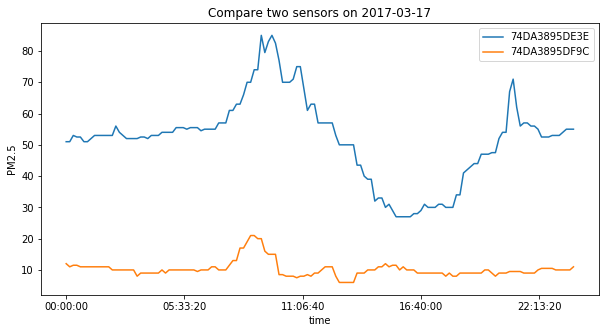

In [5]:
#compare two sensors
id1='74DA3895DE3E'#in Kaohsiung 74DA3895DE3E
id2='74DA3895DF9C'#in Hualien 74DA3895DF9C
the_date='2017-03-17'
y1 = device_dict[id1].loc[the_date]['PM2.5'].values
y2 = device_dict[id2].loc[the_date]['PM2.5'].values
x = device_dict[id1].loc[the_date].index.time
plt.figure(figsize=(10,5))
plt.plot(x, y1, label=id1)
plt.plot(x, y2, label=id2)
plt.title('Compare two sensors on ' + the_date)
plt.ylabel('PM2.5')
plt.legend()
plt.show()

**Plot  all  sensors  on  the  map  and  describe  the  dataset:**

將位置資料輸出成csv檔，再上傳到GPS Visualizer得到sensor位置圖

http://www.gpsvisualizer.com/display/data/20171011073529-43172-map.html

可以觀察到sensor分佈於亞洲、歐洲、美洲

但大部份在亞洲，尤其時台灣及韓國的資料較多

而在台灣也可觀察到西部大於東部、都市大於鄉村的現象

In [6]:
#save location as csv
#df_location.to_csv('/Users/sate/Desktop/DM/hw0/location.csv',index=False)
#http://www.gpsvisualizer.com/display/data/20171011073529-43172-map.html

**Try  to  find  some  interesting  obesrvations:**

將高雄資料取五天比較後發現，每天清晨5到7點、傍晚5到7點兩時段濃度最高，

查原因是因「太陽尚未出來或剛下山，地面廢氣在低溫下較難擴散」

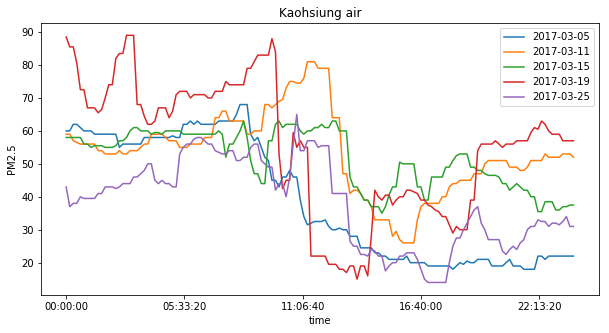

In [7]:
id1='74DA3895DE3E'#in Kaohsiung 74DA3895DE3E
the_date1='2017-03-05'
the_date2='2017-03-11'
the_date3='2017-03-15'
the_date4='2017-03-19'
the_date5='2017-03-25'
y1 = device_dict[id1].loc[the_date1]['PM2.5'].values
y2 = device_dict[id1].loc[the_date2]['PM2.5'].values
y3 = device_dict[id1].loc[the_date3]['PM2.5'].values
y4 = device_dict[id1].loc[the_date4]['PM2.5'].values
y5 = device_dict[id1].loc[the_date5]['PM2.5'].values
x = device_dict[id1].loc[the_date1].index.time
plt.figure(figsize=(10,5))
plt.plot(x, y1, label=the_date1)
plt.plot(x, y2, label=the_date2)
plt.plot(x, y3, label=the_date3)
plt.plot(x, y4, label=the_date4)
plt.plot(x, y5, label=the_date5)
plt.title('Kaohsiung air' )
plt.ylabel('PM2.5')
plt.legend()
plt.show()

## 3.Query Task
**How  many  sensors  are  there  in  the  dataset?**

A:1005 (after preprocessing)

machines內存放所有device_id

In [8]:
len(machines)

1005

**Which  sensor  recorded  the  highest  temperature  in  March?  What’s  the temperature?   And   where's   the   sensor?**

A:52.685度

經由map查詢位於新竹火車站，主觀判斷其溫度不合理有可能是sensor誤差

In [9]:
#find the highest temperature
df_result.iloc[df_result['Temperature'].idxmax()]

Date             2017-03-29
Time               13:20:00
device_id      74DA3895C3B2
PM2.5                  33.5
PM10                   43.5
PM1                    23.5
Temperature          52.685
Humidity                 23
lat                  24.801
lon                 120.972
Name: 670802, dtype: object

**What  were  the  maximal  PM2.5  values  of  each  sensors  on  3/5?**

答案為下列（nan：沒有資料）

In [10]:
for machine in machines:
    #if(device_dict[machine].loc['2017-03-05'])
    max_value = device_dict[machine][device_dict[machine].index=='2017-03-05']['PM2.5'].max()
    print(machine,max_value)

74DA3895C3AA 74.0
74DA38AF4752 nan
74DA3895C51E 52.0
74DA3895C2C4 49.0
74DA3895DEA6 83.0
74DA3895DF7A 57.0
74DA3895DFEC 63.0
74DA38AF47B6 nan
74DA38AF47F8 nan
74DA3895C376 nan
74DA38B7942A nan
74DA3895DF9E 99.0
74DA3895C5DE 59.0
74DA3895DE58 40.0
74DA3895E19A 31.0
74DA3895C36E nan
74DA3895C2BC 68.5
74DA38B79382 nan
74DA3895C27E 62.0
74DA3895DE4C 55.0
74DA38AF478C nan
74DA3895C562 43.0
74DA3895DE1E 65.0
74DA38AF489E nan
74DA3895C456 49.0
74DA3895DE94 61.0
74DA3895DE06 35.5
74DA3895C2B2 nan
74DA3895DE3A 73.0
74DA3895C22C 75.0
74DA38B79374 nan
74DA3895C374 103.0
74DA3895C3DC 58.0
74DA3895C3E2 52.5
74DA3895E16E 43.0
74DA3895DE76 72.0
74DA3895E17E 62.0
28C2DDDD45E6 nan
74DA3895C5CE 79.5
74DA3895C36C nan
74DA3895C460 50.0
74DA3895C54C 66.0
74DA38AF471E nan
74DA38AF4806 nan
74DA38AF48FC nan
74DA3895E13A 63.5
74DA38B7942C nan
74DA38AF4722 nan
74DA3895C3BE 74.0
74DA38AF4770 nan
74DA38B0516E nan
74DA3895C5B6 26.0
74DA3895E0BA 76.0
74DA38AF48DC nan
74DA3895DE78 62.0
74DA3895DE6E 68.0
74DA3895DF94

74DA38AF4724 nan
74DA38AF47C6 nan
74DA3895C270 61.0
74DA3895E034 36.0
74DA3895C316 nan
74DA3895C5C6 56.0
28C2DDDD47A8 39.0
74DA3895DE5C 78.0
74DA3895DEC0 49.0
74DA3895DEB8 69.0
74DA3895DF24 64.0
74DA3895E03E 60.0
74DA38AF47A0 nan
74DA38AF495C nan
74DA3895C252 103.0
74DA3895C266 72.0
74DA38AF4796 nan
74DA3895C3B4 42.0
74DA38A86906 nan
74DA3895C446 60.0
74DA3895C4B2 39.0
74DA3895C500 55.0
74DA3895E12E 68.0
74DA38AF4810 nan
74DA3895C558 55.0
74DA38B0530E nan
74DA388FF3BA nan
74DA3895DF76 61.0
74DA38AF4846 nan
74DA3895C34A 51.5
74DA3895E100 66.0
74DA38AF4772 nan
74DA3895DDFC 141.0
74DA3895DF34 42.0
74DA3895DFFC 53.0
74DA3895C55C 55.0
74DA3895E104 43.0
74DA3895C228 48.0
74DA3895C588 61.0
74DA3895C246 67.5
74DA3895DEEE 80.0
74DA38AF4882 nan
74DA3895DE24 61.0
74DA3895C320 69.5
74DA3895DF26 62.0
74DA38AF492A nan
74DA3895C5D8 64.0
74DA3895DF9C nan
74DA3895C59C 59.0
74DA38B7943C nan
74DA3895C23E 51.0
74DA3895C4C8 74.5
74DA3895DF38 75.0
74DA38A8693A 28.0
74DA3895C4D4 42.0
74DA3895E0F2 66.0
74DA38

**Try  to  find  some  interesting  queries.**

緯度最高的sensor經查詢後在波蘭華沙

In [11]:
df_result.iloc[df_result['lat'].idxmax()]

Date             2017-03-05
Time               13:40:00
device_id      74DA388FF552
PM2.5                  31.5
PM10                     36
PM1                    23.5
Temperature          10.435
Humidity                 80
lat                  52.182
lon                  21.001
Name: 59343, dtype: object

## 4.Time   Series   Data   Comparsion   Tasks:
### Original data
Distance:  1032.99915295

sensor位置在台南和高雄，由於這兩個資料趨勢相似又不完全一樣，適合用來觀察Time Series處理前後變化

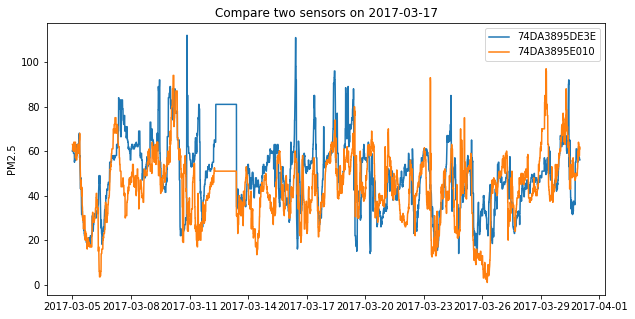

Distance:  1032.99915295


In [12]:
id1='74DA3895DE3E'#in Kaohsiung
id2='74DA3895E010'#in Tainan
data1_original = device_dict[id1].loc['2017-03-05':'2017-03-30']['PM2.5'].values
data2_original = device_dict[id2].loc['2017-03-05':'2017-03-30']['PM2.5'].values
x = device_dict[id1].loc['2017-03-05':'2017-03-30'].index
dist_original = pdist([data1_original, data2_original], 'euclidean')
plt.figure(figsize=(10,5))
plt.plot(x, data1_original, label=id1)
plt.plot(x, data2_original, label=id2)
plt.title('Compare two sensors on ' + the_date)
plt.ylabel('PM2.5')
plt.legend()
plt.show()
print('Distance: ',dist_original[0])

### Offset  Translation
Distance:  958.828581864

與原始資料相比稍微變小

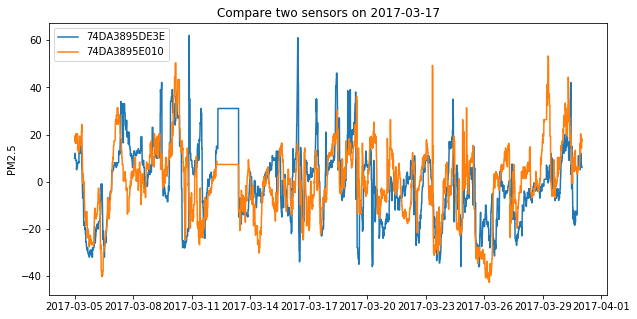

Distance:  958.828581864


In [13]:
#Offset  Translation
data1_1 = data1_original - data1_original.mean()
data2_1 = data2_original - data2_original.mean()
dist1 = pdist([data1_1, data2_1], 'euclidean')
plt.figure(figsize=(10,5))
plt.plot(x, data1_1, label=id1)
plt.plot(x, data2_1, label=id2)
plt.title('Compare two sensors on ' + the_date)
plt.ylabel('PM2.5')
plt.legend()
plt.show()
print('Distance: ',dist1[0])

### Amplitude  Scaling
Distance:  60.4541875726

距離變得極小！

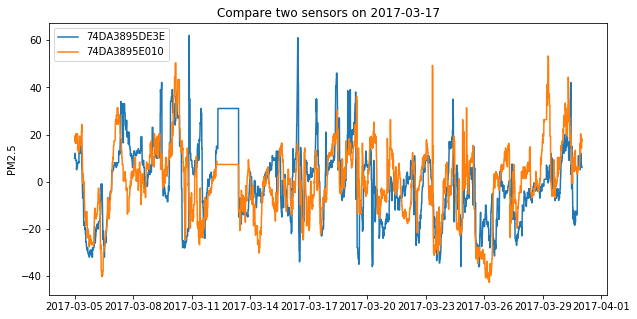

Distance:  60.4541875726


In [14]:
#Amplitude  Scaling
data1_2 = data1_1 / data1_1.std()
data2_2 = data2_1 / data2_1.std()
dist2 = pdist([data1_2, data2_2], 'euclidean')
plt.figure(figsize=(10,5))
plt.plot(x, data1_1, label=id1)
plt.plot(x, data2_1, label=id2)
plt.title('Compare two sensors on ' + the_date)
plt.ylabel('PM2.5')
plt.legend()
plt.show()
print('Distance: ',dist2[0])

### Linear Trend  Removal
Distance:  926.948189209

由於兩者沒有明顯Linear Trend，距離變化不大

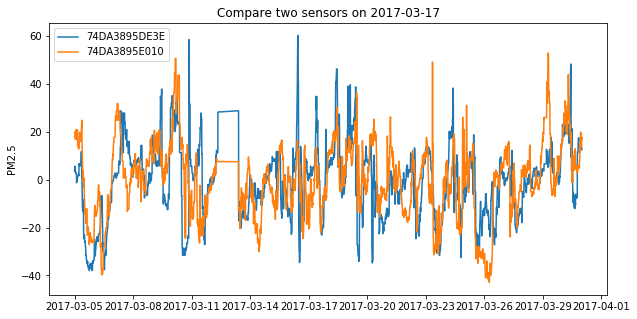

Distance:  926.948189209


In [17]:
#Linear  Trend  Removal
data1_3 = signal.detrend(data1_original)
data2_3 = signal.detrend(data2_original)
dist3 = pdist([data1_3, data2_3], 'euclidean')
plt.figure(figsize=(10,5))
plt.plot(x, data1_3, label=id1)
plt.plot(x, data2_3, label=id2)
plt.title('Compare two sensors on ' + the_date)
plt.ylabel('PM2.5')
plt.legend()
plt.show()
print('Distance: ',dist3[0])

### Noise  Removal
Distance:  137.381982882

移除雜訊後效果顯著

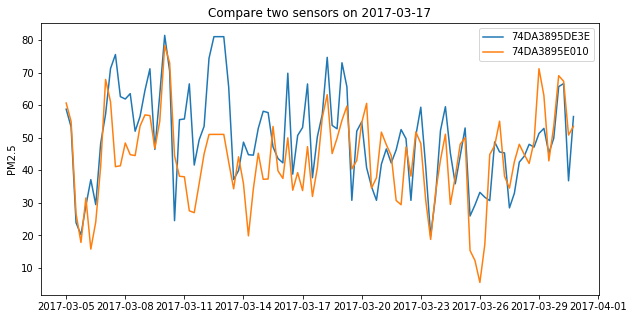

Distance:  137.381982882


In [16]:
#Noise  Removal
df1_original = device_dict[id1].loc['2017-03-05':'2017-03-30']['PM2.5']
df2_original = device_dict[id2].loc['2017-03-05':'2017-03-30']['PM2.5']
data1_4 = df1_original.resample('6H').mean().fillna(method='pad')
data2_4 = df2_original.resample('6H').mean().fillna(method='pad')
dist4 = pdist([data1_4, data2_4], 'euclidean')
plt.figure(figsize=(10,5))
plt.plot(data1_4.index, data1_4, label=id1)
plt.plot(data1_4.index, data2_4, label=id2)
plt.title('Compare two sensors on ' + the_date)
plt.ylabel('PM2.5')
plt.legend()
plt.show()
print('Distance: ',dist4[0])